In [225]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

In [226]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [238]:
from io import StringIO
from html.parser import HTMLParser
from bs4 import BeautifulSoup

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def get_latex_from_alt(context):
    strip_deliminators = lambda latex: latex.replace('$','').replace('\\[','').replace('\\]','')

    context_soup = BeautifulSoup(context)
    latex_images = context_soup.find_all('img')
    for image in latex_images:
        image.replace_with(strip_deliminators(image['alt']))
    # return [strip_deliminators(image['alt']) for image in latex_images]
    return str(context_soup)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [224]:
get_latex_from_alt('<html><head></head><body><p>In the following list of numbers, the integer <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> appears <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> times in the list for <img alt=\"$1 \\leq n \\leq 200$\" class=\"latex\" height=\"15\" src=\"//latex.artofproblemsolving.com/9/1/7/917e3430450e9049864739d088103bef0598a899.png\" style=\"vertical-align: -2px\" width=\"95\"/>.<img alt=\"\\[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200\\]\" class=\"latexcenter\" height=\"16\" src=\"//latex.artofproblemsolving.com/f/4/f/f4f50e6ad3c33b14e7352b50ecc5ff8322c37702.png\" width=\"332\"/>What is the median of the numbers in this list?\n</p><p>\n</p></body></html>')

<html><head></head><body><p>In the following list of numbers, the integer n appears n times in the list for 1 \leq n \leq 200.1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \ldots, 200, 200, \ldots , 200What is the median of the numbers in this list?
</p><p>
</p></body></html>

In [228]:
con = sqlite3.connect('site/amc10_problems.db')

cursor = con.cursor()
cursor.execute('SELECT * FROM problem')

problems_data = pd.DataFrame(cursor.fetchall(), columns=['id','test','number','choices','problem','answer','labels','difficulty'])

In [229]:
problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

problems_data.head(5)

,id,test,number,choices,problem,answer,labels,difficulty,year,instance
0,1,"[2015, 10, A]",1,"[""\\ -125"", ""\\ -120"", ""\\ \\frac{1}{5}"", ""\\ ...",<html><head></head><body><p>What is the value ...,"""C""",None,1,2015,A
1,2,"[2015, 10, A]",2,"[""\\ 3"", ""\\ 5"", ""\\ 7"", ""\\ 9"", ""\\ 11""]",<html><head></head><body><p>A box contains a c...,"""D""",None,1,2015,A
2,3,"[2015, 10, A]",3,"[""\\ 9"", ""\\ 18"", ""\\ 20"", ""\\ 22"", ""\\ 24""]",<html><head></head><body><p>Ann made a <img al...,"""D""",None,1,2015,A
3,4,"[2015, 10, A]",4,"[""\\ \\frac{1}{12}"", ""\\ \\frac{1}{6}"", ""\\ \\...","<html><head></head><body><p>Pablo, Sofia, and ...","""B""",None,1,2015,A
4,5,"[2015, 10, A]",5,"[""\\ 81"", ""\\ 85"", ""\\ 91"", ""\\ 94"", ""\\ 95""]",<html><head></head><body><p>Mr. Patrick teache...,"""E""",None,1,2015,A


In [230]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022'], dtype=object)

In [231]:
problems_data = problems_data[problems_data['year'].isin(['2020', '2021_Fall', '2021', '2022'])]
problems_data.set_index('id')

,test,number,choices,problem,answer,labels,difficulty,year,instance
id,,,,,,,,,
244,"[2020, 10, A]",1,"[""\\ {-}\\frac{2}{3}"", ""\\ \\frac{7}{36}"", ""\\...",<html><head></head><body><p>What value of <img...,"""E""",None,1,2020,A
245,"[2020, 10, A]",2,"["" 0 "", "" 15 "", "" 30 "", "" 45 "", "" 60""]",<html><head></head><body><p>The numbers <img a...,"""C""",None,1,2020,A
246,"[2020, 10, A]",3,"["" {-}1 "", "" 1 "", "" \\frac{abc}{60} "", "" \\...",<html><head></head><body><p>Assuming <img alt=...,"""A""",None,1,2020,A
247,"[2020, 10, A]",4,"[""\\ 20"", ""\\ 22"", ""\\ 24"", ""\\ 25"", ""\\ 26""]",<html><head></head><body><p>A driver travels f...,"""E""",None,1,2020,A
248,"[2020, 10, A]",5,"["" 12 "", "" 15 "", "" 18 "", "" 21 "", "" 25""]",<html><head></head><body><p>What is the sum of...,"""C""",None,1,2020,A
...,...,...,...,...,...,...,...,...,...
438,"[2022, 10, B]",21,"[""\\ 10 "", ""\\ 13 "", ""\\ 19 "", ""\\ 20 "", ""\\ 23""]","<html><head></head><body><p>Let <img alt=""$P(x...","""E""",None,5,2022,B
439,"[2022, 10, B]",22,"[""~48\\pi"", ""~68\\pi"", ""~96\\pi"", ""~102\\pi"", ...","<html><head></head><body><p>Let <img alt=""$S$""...","""E""",None,5,2022,B
440,"[2022, 10, B]",23,"[""\\frac{1}{3} "", ""\\frac{1}{2} "", ""\\frac{2...",<html><head></head><body><p>Ant Amelia starts ...,"""C""",None,5,2022,B


In [232]:
labeled_data = pd.read_csv('problem_labels.csv').replace([True,False],[1,0])
labeled_data.shape

(200, 83)

In [233]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,Dice Problems,Card Problems,Placing/Picking/Labeling Problems,Stars and Bars,Expected Value,Recursive Counting,Conditional Probability,Complementary Counting,States,Principle of Inclusion-Exclusion
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020,10,B,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,2020,10,B,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,2020,10,B,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,2020,10,B,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
misc_labels = (6,22)
alg_labels = (23,43)
geo_labels = (44,61)
nt_labels = (62,69)
cb_labels = (69,82)

def extract_labels(cols):
    start, end = cols
    return labeled_data[labeled_data.columns[start:end]].values.tolist()

In [235]:
labeled_data['misc-labels'] = extract_labels(misc_labels)
labeled_data['alg-labels'] = extract_labels(alg_labels)
labeled_data['geo-labels'] = extract_labels(geo_labels)
labeled_data['nt-labels'] = extract_labels(nt_labels)
labeled_data['cb-labels'] = extract_labels(cb_labels)

labeled_data['Miscellaneous'] = labeled_data['misc-labels'].apply(lambda x: int(any(x)))
labeled_data['Combinatorics'] = labeled_data['cb-labels'].apply(lambda x: int(any(x)))

In [236]:
labeled_data['tl-labels'] = labeled_data[['Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics']].values.tolist()

labeled_data = labeled_data[['Year','Instance','Problem',
                             'Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics',
                             'misc-labels','alg-labels','geo-labels','nt-labels','cb-labels','tl-labels',]]
labeled_data

,Year,Instance,Problem,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2022,A,1,1,1,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
1,2022,A,2,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
2,2022,A,3,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
3,2022,A,4,1,1,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
4,2022,A,5,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020,B,21,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
196,2020,B,22,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
197,2020,B,23,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
198,2020,B,24,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"


In [239]:
problems_data = problems_data[['year','instance','number','choices','problem']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['choices'] = problems_data['choices'].map(lambda x: ' '.join(json.loads(x)))
problems_data['context'] = problems_data['problem'] + problems_data['choices']
problems_data.drop(columns=['problem','choices'],inplace=True)
labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_98975/3010592191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)


In [240]:
problems_data = problems_data.merge(right=labeled_data,on=['year','instance','number'])
problems_data

,year,instance,number,context,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2020,A,1,What value of x satisfies\nx- \frac{3}{4} = \f...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
1,2020,A,2,"The numbers 3, 5, 7, a, and b have an average ...",1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
2,2020,A,3,"Assuming a\neq3, b\neq4, and c\neq5, what is t...",0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
3,2020,A,4,A driver travels for 2 hours at 60 miles per h...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
4,2020,A,5,What is the sum of all real numbers x for whic...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2022,B,21,Let P(x) be a polynomial with rational coeffic...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
195,2022,B,22,Let S be the set of circles in the coordinate ...,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
196,2022,B,23,Ant Amelia starts on the number line at 0 and ...,1,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 1]"
197,2022,B,24,Consider functions f that satisfy |f(x)-f(y)|\...,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"


In [241]:
problems_data['context'].iloc[0]

'What value of x satisfies\nx- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}?\n\n\\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [242]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-05

In [243]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)

In [244]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe[labels]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [245]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)

In [246]:
training_dataset = MultiLabelDataset(training_data, tokenizer, 'tl-labels', MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, 'tl-labels', MAX_LEN)

In [247]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [248]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [249]:
top_level_model = DistilBERTClass(num_classes=5)
top_level_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [250]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [251]:
optimizer = torch.optim.Adam(params =  top_level_model.parameters(), lr=LEARNING_RATE)

In [254]:
class ModelTraining:
    def __init__(self, model, training_loader, testing_loader, optimizer):
        self.model = model
        self.training_loader = training_loader
        self.optimizer = optimizer
        self.testing_loader = testing_loader
    
    def train_model(self,epoch):
        self.model.train()
        for _, data in enumerate(self.training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = self.model(ids, mask)

            self.optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%1000==0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def validation(self):
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for _, data in enumerate(self.testing_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = self.model(ids, mask)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

In [255]:
model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)
for epoch in range(EPOCHS):
    model_trainer.train_model(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.7166673541069031
Epoch: 1, Loss: 0.5942842364311218
Epoch: 2, Loss: 0.49695122241973877
Epoch: 3, Loss: 0.5357390642166138
Epoch: 4, Loss: 0.5088032484054565
Epoch: 5, Loss: 0.41089168190956116
Epoch: 6, Loss: 0.3528912365436554
Epoch: 7, Loss: 0.39156389236450195
Epoch: 8, Loss: 0.35128703713417053
Epoch: 9, Loss: 0.2769385278224945
Epoch: 10, Loss: 0.2217378467321396
Epoch: 11, Loss: 0.22709129750728607
Epoch: 12, Loss: 0.2239389568567276
Epoch: 13, Loss: 0.1866561323404312
Epoch: 14, Loss: 0.21328720450401306
Epoch: 15, Loss: 0.144638329744339
Epoch: 16, Loss: 0.134932741522789
Epoch: 17, Loss: 0.11410011351108551
Epoch: 18, Loss: 0.13263842463493347
Epoch: 19, Loss: 0.12875020503997803


In [199]:
# torch.save(top_level_model,'top-level-distilbert-amc10-2020-2022.pt')

In [200]:
# model = torch.load('top-level-distilbert-amc10-2020-2022.pt')

In [201]:
# def validation(testing_loader):
#     model.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader):
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.float)
#             outputs = top_level_model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
#     return fin_outputs, fin_targets

Accuracy Score = 0.825
F1 Score (Micro) = 0.9
F1 Score (Macro) = 0.8742857142857143


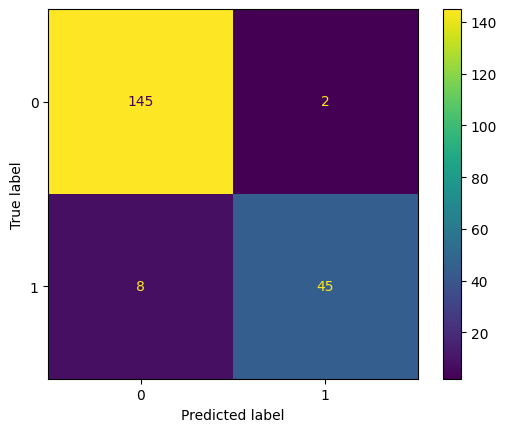

In [256]:
from itertools import chain

outputs, targets = model_trainer.validation()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
# for cm in metrics.multilabel_confusion_matrix(targets,outputs):
#     matrix = metrics.ConfusionMatrixDisplay(cm)
#     matrix.plot()
# single_label_accuracy = metrics.accuracy_score(list(chain.from_iterable(targets)), list(chain.from_iterable(outputs)))
# print(f"Single-label Accuracy Score = {single_label_accuracy}")

In [ ]:
# outputs, targets = validation(testing_loader)
# import matplotlib.pyplot as plt

# plt.figure(figsize=(2,8))
# for i in range(len(targets)):
#     plt.scatter(targets[i],outputs[i],s=.2)
# plt.hlines(.5,0,1)
# plt.show()

In [257]:
def generate_model(dataframe, labels):
    training_data = dataframe.sample(frac=train_size, random_state=200).reset_index(drop=True)
    validation_data = dataframe.drop(training_data.index).reset_index(drop=True)

    training_dataset = MultiLabelDataset(training_data, tokenizer, labels, MAX_LEN)
    val_dataset = MultiLabelDataset(validation_data, tokenizer, labels, MAX_LEN)

    training_loader = DataLoader(training_dataset, **train_params)
    testing_loader = DataLoader(val_dataset, **test_params)

    model = DistilBERTClass(len(dataframe[labels].iloc[0]))
    model.to(device)

    return model, training_loader, testing_loader

In [258]:
alg_data = problems_data.loc[problems_data['Algebra'] == True]
alg_data = alg_data[['year','instance','number','context','alg-labels']].reset_index()

In [259]:
alg_model, alg_training_loader, alg_testing_loader = generate_model(alg_data, 'alg-labels')
alg_optimizer = torch.optim.Adam(params=alg_model.parameters(), lr=LEARNING_RATE)
model_trainer = ModelTraining(alg_model, alg_training_loader, alg_testing_loader, alg_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [260]:
for epoch in range(40):
    model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6991798281669617
Epoch: 1, Loss: 0.645022988319397
Epoch: 2, Loss: 0.5801562666893005
Epoch: 3, Loss: 0.5390824675559998
Epoch: 4, Loss: 0.49086564779281616
Epoch: 5, Loss: 0.46480682492256165
Epoch: 6, Loss: 0.45201221108436584
Epoch: 7, Loss: 0.4350419342517853
Epoch: 8, Loss: 0.43117034435272217
Epoch: 9, Loss: 0.390062153339386
Epoch: 10, Loss: 0.3814275860786438
Epoch: 11, Loss: 0.3830394446849823
Epoch: 12, Loss: 0.3555513024330139
Epoch: 13, Loss: 0.32296448945999146
Epoch: 14, Loss: 0.31843453645706177
Epoch: 15, Loss: 0.33154377341270447
Epoch: 16, Loss: 0.29683181643486023
Epoch: 17, Loss: 0.2868121564388275
Epoch: 18, Loss: 0.27209073305130005
Epoch: 19, Loss: 0.2913767695426941
Epoch: 20, Loss: 0.29655101895332336
Epoch: 21, Loss: 0.2946455776691437
Epoch: 22, Loss: 0.2610902786254883
Epoch: 23, Loss: 0.26353919506073
Epoch: 24, Loss: 0.2391388714313507
Epoch: 25, Loss: 0.27459952235221863
Epoch: 26, Loss: 0.2852235436439514
Epoch: 27, Loss: 0.250458031892

Accuracy Score = 0.0
F1 Score (Micro) = 0.0
F1 Score (Macro) = 0.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


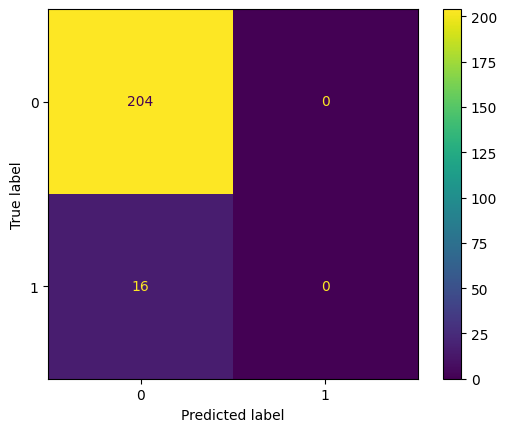

In [261]:
outputs, targets = model_trainer.validation()
outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
geo_data = problems_data.loc[problems_data['Geometry'] == True]
geo_data = geo_data[['year','instance','number','context','geo-labels']].reset_index()
geo_data

In [ ]:
geo_model, geo_training_loader, geo_testing_loader = generate_model(geo_data, 'geo-labels')
geo_optimizer = torch.optim.Adam(params=geo_model.parameters(), lr=LEARNING_RATE)
model_trainer = ModelTraining(geo_model, geo_training_loader, geo_testing_loader, geo_optimizer)

In [ ]:
for epoch in range(40):
    model_trainer.train_model(epoch)

In [ ]:
outputs, targets = model_trainer.validation()
outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
outputs, targets = model_trainer.validation()
import matplotlib.pyplot as plt

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()